In [179]:
!pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 KB 1.6 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [13]:
!pip install --upgrade tensorflow-hub

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
  Using cached sentencepiece-0.1.97-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [25]:
!pip install hnswlib

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.6.2-cp310-cp310-linux_x86_64.whl size=2080146 sha256=24fd41dc0166d22d2d94e6c455ebb4f72c6cfd72907ed9ea57d6ea2de6ea3121
  Stored in directory: /home/dylan/.cache/pip/wheels/b3/51/94/2e27c3c7bddd94d1ca6852f497e9ad7989d3f1e0dcf551e10b
Successfully built hnswlib


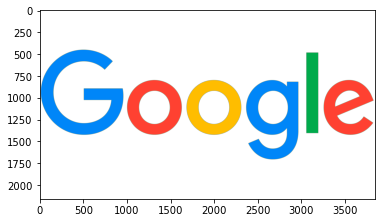

In [228]:
plt.imshow(mpimg.imread('../static/images/Google-logo.png'))

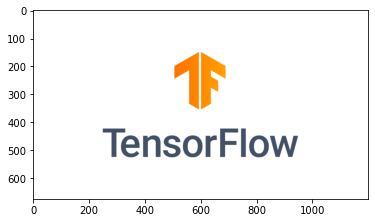

In [227]:
plt.imshow(mpimg.imread('../static/images/tf_logo_social.png'))

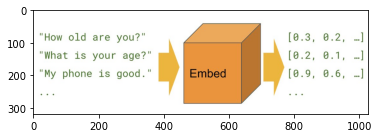

In [232]:
plt.imshow(mpimg.imread('../static/images/USE.jpg'))

@misc{https://doi.org/10.48550/arxiv.1803.11175,
  doi = {10.48550/ARXIV.1803.11175},
  
  url = {https://arxiv.org/abs/1803.11175},
  
  author = {Cer, Daniel and Yang, Yinfei and Kong, Sheng-yi and Hua, Nan and Limtiaco, Nicole and John, Rhomni St. and Constant, Noah and Guajardo-Cespedes, Mario and Yuan, Steve and Tar, Chris and Sung, Yun-Hsuan and Strope, Brian and Kurzweil, Ray},
  
  keywords = {Computation and Language (cs.CL), FOS: Computer and information sciences, FOS: Computer and information sciences},
  
  title = {Universal Sentence Encoder},
  
  publisher = {arXiv},
  
  year = {2018},
  
  copyright = {arXiv.org perpetual, non-exclusive license}
}


@misc{https://doi.org/10.48550/arxiv.1603.09320,
  doi = {10.48550/ARXIV.1603.09320},
  
  url = {https://arxiv.org/abs/1603.09320},
  
  author = {Malkov, Yu. A. and Yashunin, D. A.},
  
  keywords = {Data Structures and Algorithms (cs.DS), Computer Vision and Pattern Recogniti on (cs.CV), Information Retrieval (cs.IR), Social and Information Networks (cs.SI), FOS: Computer and information sciences, FOS: Computer and information sciences},
  
  title = {Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs},
  
  publisher = {arXiv},
  
  year = {2016},
  
  copyright = {arXiv.org perpetual, non-exclusive license}
}



Welcome to a use of TensorFlow, TensorFlow Model Hub, and Google's Universal Sentence Encode to perform feature extraction on the University of Southern Indiana's 2022-2023 description of all courses. To do our work requires some basic NLP text parsing skills to create a dataset, and from there we can obtain our embeddings (aka feature vectors). After creating embeddings (aka feature vectors) of all descriptions we will create a Hierarchical Navigable Small World graph of our embeddings to query our vectors for the most similar vector using cosine similarity.

Surprisingly, the results are pretty good without doing ANY transfer learning!

In [1]:
with open('dept_ids.txt', 'r') as dept_ids:
    data = dept_ids.read()
    dept_names = data.split(' ')
    dept_names.remove("\n")
    print(dept_names)

['ACCT', 'ADV', 'AFRC', 'AGBU', 'AHA', 'ANTH', 'ARAB', 'ART', 'ARTD', 'ARTE', 'ARTH', 'ARTP', 'ASTR', 'BAN', 'BCOM', 'BIOL', 'BLAW', 'BUAD', 'CE', 'CHEM', 'CHIN', 'CIS', 'CMST', 'COMM', 'CRIM', 'CS', 'DMS', 'DSCI', 'DTAS', 'DTHY', 'DVT', 'ECE', 'ECHO', 'ECON', 'EDUC', 'ENG', 'ENGR', 'EXSC', 'FIN', 'FREN', 'GENS', 'GEOG', 'GEOL', 'GERM', 'GERO', 'GLST', 'GNDR', 'HA', 'HI', 'HIST', 'HONS', 'HP', 'HUM', 'IEP', 'IME', 'IPH', 'JPN', 'JRN', 'KIN', 'LATN', 'LIBA', 'MATH', 'ME', 'MFET', 'MKTG', 'MNGT', 'MS', 'MUS', 'NURS', 'NUTR', 'OTA', 'PET', 'PH', 'PHIL', 'PHYS', 'POLS', 'PRFS', 'PRL', 'PSY', 'RADT', 'RELS', 'REST', 'RTV', 'SOC', 'SOCW', 'SPAN', 'SPTM', 'STAT', 'STEM', 'TECH', 'THTR', 'UNIV', 'WLC']


We will now parse through our text. We will want a dictionary object for each course. First we will find the lines that start with the department names and then fill in our dictionary with that info, then add the subsequent text as our course description.


JSON: courses[[{course_dept:DEPT, course_number:COURSE_NUM, course_title:COURSE_TILE, course_description:COURSE_DESCRIPTION, 'USE_embedding': None}]]

In [2]:
import re
import json


courses = []

registrar_file = open('output.txt')
registrar_file_iter = iter(registrar_file)

for line in registrar_file_iter:
    if line.startswith(tuple(dept_names)):
        course_dict = {'course_dept': '', 'course_number': '', 'course_title':'', 'course_description':'', 'USE_embedding': None}
        course_description = ''
        line_split = line.split(" ")
        course_dict['course_dept'] = line_split[0]
        course_dict['course_number'] = line_split[1]
        course_dict['course_title'] = " ".join(line_split[3:-1])
        line = next(registrar_file_iter)
        while not line.startswith(tuple(dept_names)):
            line.rstrip()
            course_description = course_description+line
            line = next(registrar_file_iter)
        course_description = re.sub('\n' ,'', course_description)          
        course_dict['course_description'] = course_description
        courses.append(course_dict)


In [3]:
print(courses)

[{'course_dept': 'ACCT', 'course_number': '201', 'course_title': 'Accounting Principles I', 'course_description': "Credits: 3  Required: Business Core requirement for all business majors. A study of the principles of financial accounting and reporting as they relate to today's business environment. Both the procedures used and the concepts upon which they are based will be studied.  Prereq (may be taken concurrently): CIS 201  This course is part of the Core Transfer Library (CTL) Term(s) Offered: Fall, Spring, Summer ", 'USE_embedding': None}, {'course_dept': 'ACCT', 'course_number': '303', 'course_title': 'Intermediate Accounting I', 'course_description': 'Credits: 3  Required: Required for all accounting majors. An intensive study and application of Generally Accepted Accounting Principles (GAAP) for asset valuation, income measurement, and financial statement presentation for business organizations, including the processes through which GAAP has evolved. The emphasis in this course

In [229]:
#with open('data.json', "w") as f:
 #   json.dump(courses, f)

In [4]:
print(courses[420]['course_description'])

Credits: 3  This course focuses on healthcare marketing and strategic planning in healthcare. The increasing complexity of the healthcare system dictates a need for an organized approach to strategy, and one that ties key market issues and needs to a definitive market position, quantifiable objectives, and finally to strategies and actions aimed at achieving the position and objectives. This course allows the student to learn such an organized approach to marketing and strategy. A strategic analysis and plan, as a means to introduce the principles and concepts of strategy applicable to healthcare, will be conducted.  Prerequisite(s): Grade of C or better in HP 211; junior standing  Term(s) Offered: Fall, Spring, Summer Health Informatics and Information Management 


To proceed with out work from Notebook 1, we will have to install required packages for doing our vectorization of our course descriptions found in the list and JSON object created in Notebook 1. 



Beginning Notebook 2:

# Verify your packages installed correctly, and that TensorFlow sees your GPU.

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from absl import logging

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sentencepiece as spm

2022-09-15 18:19:52.579296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 18:19:54.228255: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-15 18:19:55.339521: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 18:20:01.137749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
tf.config.list_physical_devices('GPU')

2022-09-15 18:20:13.918899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 18:20:14.473803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 18:20:14.474047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Load the Universal Sentence Encord from the TensorFlow model hub, and define a function to create an embedding from the model.


Source of Code: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [16]:
module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")

In [17]:
input_placeholder = tf.sparse_placeholder(tf.int64, shape=[None, None])
encodings = module(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [18]:
with tf.Session() as sess:
  spm_path = sess.run(module(signature="spm_path"))

sp = spm.SentencePieceProcessor()
with tf.io.gfile.GFile(spm_path, mode="rb") as f:
  sp.LoadFromSerializedProto(f.read())
print("SentencePiece model loaded at {}.".format(spm_path))


2022-09-13 16:42:29.020714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:29.020948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:29.021044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:29.021162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:29.021236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


SentencePiece model loaded at b'/tmp/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model'.


In [19]:
def process_to_IDs_in_sparse_format(sp, sentences):
  # An utility method that processes sentences with the sentence piece processor
  # 'sp' and returns the results in tf.SparseTensor-similar format:
  # (values, indices, dense_shape)
  ids = [sp.EncodeAsIds(x) for x in sentences]
  max_len = max(len(x) for x in ids)
  dense_shape=(len(ids), max_len)
  values=[item for sublist in ids for item in sublist]
  indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
  return (values, indices, dense_shape)

In [20]:
messages = []

for course in courses:
    
    course_description = (course['course_description'])
    messages.append(course_description)

In [21]:
values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)

In [22]:
# Reduce logging output.
logging.set_verbosity(logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

2022-09-13 16:42:33.348974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:33.349195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:33.349306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:33.349467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-13 16:42:33.349550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Message: Credits: 3  Required: Business Core requirement for all business majors. A study of the principles of financial accounting and reporting as they relate to today's business environment. Both the procedures used and the concepts upon which they are based will be studied.  Prereq (may be taken concurrently): CIS 201  This course is part of the Core Transfer Library (CTL) Term(s) Offered: Fall, Spring, Summer 
Embedding size: 512
Embedding: [-0.012920504435896873, -0.08410733938217163, -0.05674325302243233, ...]

Message: Credits: 3  Required: Required for all accounting majors. An intensive study and application of Generally Accepted Accounting Principles (GAAP) for asset valuation, income measurement, and financial statement presentation for business organizations, including the processes through which GAAP has evolved. The emphasis in this course is on the basic financial statements and related footnotes, the time value of money, the valuation and presentation of assets, curren

Let's have a look at one of our datapoint in the list of courses. Notice that they key, "description_vector_USE"

In [24]:
print(message_embeddings)

print(courses[0]["USE_embedding"])



[[-0.0129205  -0.08410734 -0.05674325 ... -0.0755034  -0.0211434
   0.02645107]
 [ 0.03963647 -0.06643433 -0.01189352 ... -0.08149649 -0.01481179
   0.02451058]
 [-0.04366382 -0.05323188 -0.03161876 ... -0.02157048  0.01100708
  -0.01794065]
 ...
 [-0.05882639 -0.02008378 -0.06143328 ... -0.06864892  0.0233821
  -0.00064509]
 [-0.04172241 -0.05205835 -0.07132331 ... -0.07318141  0.06414524
   0.02653285]
 [-0.0627334  -0.07747706 -0.07575883 ... -0.04196411  0.00932382
  -0.00525239]]
None


In [25]:
for i, message_embedding in enumerate(message_embeddings):
    ##print(message_embedding)
    courses[i]['USE_embedding'] = message_embedding.tolist()

In [26]:
print(courses[0])

{'course_dept': 'ACCT', 'course_number': '201', 'course_title': 'Accounting Principles I', 'course_description': "Credits: 3  Required: Business Core requirement for all business majors. A study of the principles of financial accounting and reporting as they relate to today's business environment. Both the procedures used and the concepts upon which they are based will be studied.  Prereq (may be taken concurrently): CIS 201  This course is part of the Core Transfer Library (CTL) Term(s) Offered: Fall, Spring, Summer ", 'USE_embedding': [-0.012920504435896873, -0.08410733938217163, -0.05674325302243233, 0.03039158694446087, -0.05671803280711174, 0.016067853197455406, -0.07532548159360886, -0.07027757912874222, 0.06481295824050903, 0.00773771433159709, -0.03503003343939781, 0.04922584071755409, 0.00376737373881042, 0.03224732354283333, -0.0570121593773365, -0.05892997607588768, -0.05909448862075806, -0.06386925280094147, -0.059759825468063354, 0.050222575664520264, -0.03582587093114853,

Compute a representation for each message, showing various lengths supported.

Source: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [214]:
print(len(np.array(message_embeddings)))


844


In [216]:
for key, value in courses[0].items():
    print(key)

course_dept
course_number
course_title
course_description
USE_embedding


Create an HNSW (Hierarchical Navigable Small World) Graph of All of the Vector Datapoints of our Embeddings. We are using a cosine space as this is what Google has used in the demonstrations of the Universal Sentence Encoder, at least in my research. This graph will be used to query for the most similar vectors.

Source: https://arxiv.org/abs/1603.09320
Source: https://github.com/nmslib/hnswlib


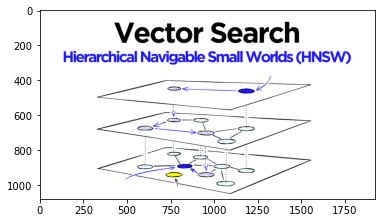

In [226]:
plt.imshow(mpimg.imread('../static/images/hnsw-0.jpg'))

In [27]:
import hnswlib
import numpy as np
import pickle

dim = 512
num_elements = len(courses)
print("length of courses is: " + str(num_elements))

# Generating sample data
data = message_embeddings
ids = np.arange(num_elements)

# Declaring index
p = hnswlib.Index(space = 'cosine', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

# Element insertion (can be called several times):
p.add_items(data, ids)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(data[300], k = 5)

length of courses is: 844


In [32]:
print(courses[420])

{'course_dept': 'HA', 'course_number': '496', 'course_title': 'Marketing and Competitive Strategy in Healthcare', 'course_description': 'Credits: 3  This course focuses on healthcare marketing and strategic planning in healthcare. The increasing complexity of the healthcare system dictates a need for an organized approach to strategy, and one that ties key market issues and needs to a definitive market position, quantifiable objectives, and finally to strategies and \x0cactions aimed at achieving the position and objectives. This course allows the student to learn such an organized approach to marketing and strategy. A strategic analysis and plan, as a means to introduce the principles and concepts of strategy applicable to healthcare, will be conducted.  Prerequisite(s): Grade of C or better in HP 211; junior standing  Term(s) Offered: Fall, Spring, Summer Health Informatics and Information Management ', 'USE_embedding': [0.028294915333390236, -0.07741225510835648, -0.0383295230567455

In [28]:
labels, distances = p.knn_query(data[420], k = 5)

In [29]:
print(message_embeddings[0])
print(message_embeddings)

[-0.0129205  -0.08410734 -0.05674325  0.03039159 -0.05671803  0.01606785
 -0.07532548 -0.07027758  0.06481296  0.00773771 -0.03503003  0.04922584
  0.00376737  0.03224732 -0.05701216 -0.05892998 -0.05909449 -0.06386925
 -0.05975983  0.05022258 -0.03582587 -0.05997446  0.01629461  0.0559931
  0.05901966  0.04663385 -0.04883322  0.02436421 -0.03053911 -0.02316966
  0.00952827  0.03709819  0.04590854 -0.01724627  0.03624757  0.07684866
 -0.01818296  0.06916034 -0.08896596 -0.00314693  0.04229602  0.00794638
  0.05729406 -0.0854744   0.00237194  0.01141504 -0.01609094 -0.06293944
  0.05990816  0.05094616  0.03784409  0.03051367 -0.03558149  0.01407461
 -0.0185773   0.05267497  0.01863382 -0.02305075  0.05998062 -0.05863695
 -0.06155055 -0.0106594  -0.01849912 -0.03132077  0.01815456  0.00786218
  0.08461008  0.0154197   0.05328365  0.01107297 -0.06610443 -0.01695637
 -0.06495781  0.04436339  0.01677709 -0.01406195 -0.04619304  0.07131445
 -0.03284545  0.0250968  -0.0011361  -0.04914163 -0.

Use our labels, indicating index of each vector returned from doing a K-NN search, to look at the titles of our recommended courses. Seems to make good recommendations.

In [30]:
print(labels[0])
results = labels[0].tolist()

for index in results:
    print(courses[index]['course_title'])

[420 434 588 416 419]
Marketing and Competitive Strategy in Healthcare
Professionalism in Health Care
Care Coordination in Professional Nursing Practice
Issues in Health Care Leadership
Internship in Health Administration I


In [31]:
p.save_index("index.bin")

In [7]:
print(courses)

[{'course_dept': 'ACCT', 'course_number': '201', 'course_title': 'Accounting Principles I', 'course_description': "Credits: 3  Required: Business Core requirement for all business majors. A study of the principles of financial accounting and reporting as they relate to today's business environment. Both the procedures used and the concepts upon which they are based will be studied.  Prereq (may be taken concurrently): CIS 201  This course is part of the Core Transfer Library (CTL) Term(s) Offered: Fall, Spring, Summer ", 'USE_embedding': None}, {'course_dept': 'ACCT', 'course_number': '303', 'course_title': 'Intermediate Accounting I', 'course_description': 'Credits: 3  Required: Required for all accounting majors. An intensive study and application of Generally Accepted Accounting Principles (GAAP) for asset valuation, income measurement, and financial statement presentation for business organizations, including the processes through which GAAP has evolved. The emphasis in this course

In [22]:
#print(courses[0])
#print(courses[0]['course_dept'] + " " + courses[0]['course_number'] + " " + courses[0]['course_title'])
#print(courses[0]['course_description'])

for x in courses:
    print(x['course_dept'] + " " + x['course_number'] + " " + x['course_title'])

ACCT 201 Accounting Principles I
ACCT 303 Intermediate Accounting I
ACCT 311 Introduction to Federal Income Taxation
ACCT 390 Individual Taxation Practicum
ACCT 411 Taxation of Corporations and Partnerships
ACCT 415 Auditing Theory and Practice
ACCT 422 Financial Report and Analysis
ACCT 451 Accounting for Investments I: Equity and Alternative Assets
ACCT 453 Alternative Investments: Uses and Recording
ACCT 465 Accounting Ethics & Compliance
ADV 101 Introduction to Advertising
ADV 342 Advertising Design
ADV 346 Special Events and Promotion
ADV 400 Independent Study in Advertising
ADV 441 Seminar in Integrated Marketing Communications
ADV 446 Seminar in Advertising
AFRC 111 Introduction to Africana Studies
AFRC 311 Africana Studies Perspectives
AFRC 331 Field Experience in the Modern Civil Rights Movement
AFRC 400 Africana Topics
AGBU 303 Farm and Ranch Management
AGBU 399 Special Topics in Agricultural Business
ANTH 111 Introduction to Cultural Anthropology
ANTH 131 Introduction to Phy

In [24]:
print(courses[420]['course_description'])

Credits: 3  This course focuses on healthcare marketing and strategic planning in healthcare. The increasing complexity of the healthcare system dictates a need for an organized approach to strategy, and one that ties key market issues and needs to a definitive market position, quantifiable objectives, and finally to strategies and actions aimed at achieving the position and objectives. This course allows the student to learn such an organized approach to marketing and strategy. A strategic analysis and plan, as a means to introduce the principles and concepts of strategy applicable to healthcare, will be conducted.  Prerequisite(s): Grade of C or better in HP 211; junior standing  Term(s) Offered: Fall, Spring, Summer Health Informatics and Information Management 


In [ ]:
example_dictionary = {'key0': None, 'key1': 'something'}